In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import imageio
import os

In [2]:
nodos = 100
L = 1
k = 1
w = 1
theta_B = 40

In [3]:
def eficiencia(perfil,params):
    
    L,k,h,B0,B1,w,theta_B = params
    
    perfil_inferior = B1*(1-np.linspace(0,1,nodos))
    P = 2*(perfil+perfil_inferior+w)
    A = (perfil_inferior+perfil)*w
    dx = L/nodos

    coeficientes = np.zeros((nodos,nodos))
    coeficientes[0,0] = 1 #Theta(0) = Theta_B
    
    coeficientes[-1,-1] = 3
    coeficientes[-1,-2] = -4
    coeficientes[-1,-3] = 1 #theta_i-2 - 4theta_i-1 + 3theta_i = 2theta_prima*deltaX

    constantes = np.zeros(nodos)
    constantes[0] = theta_B

    for i in range(1,nodos-1):

        coeficientes[i,i] = -2*A[i] - (h/k)*P[i]*dx**2
        coeficientes[i,i-1] = A[i]-(A[i+1]-A[i-1])/4
        coeficientes[i,i+1] = A[i]+(A[i+1]-A[i-1])/4

    A_inv = np.linalg.inv(coeficientes)
    Thetas = np.matmul(A_inv,constantes)
    
    Q = np.trapz(h*P*Thetas,np.linspace(0,L,nodos))
    Qm = np.trapz(h*P*theta_B,np.linspace(0,L,nodos))
    Eta = Q/Qm
    return Eta, Thetas

In [4]:
h = 0.2
B0 = 0.3
B1 = 0.3
perfil_tri = B0-np.linspace(0,B0,nodos)
params = L,k,h,B0,B1,w,theta_B
etaTri,thetasTri = eficiencia(perfil_tri,params)

h = 0.2
B0 = 0.3
B1 = 0
perfil_rect = B0*np.ones(nodos)
params = L,k,h,B0,B1,w,theta_B
etaRect,thetasRect = eficiencia(perfil_rect,params)

In [5]:
print('--------------------------------------------------------------')
print('--------------------------------------------------------------')
print()
print('Eficiencia aleta triangular = {:.3f}'.format(etaTri))
print('Eficiencia aleta rectangular = {:.3f}'.format(etaRect))
print()
print('--------------------------------------------------------------')
print('--------------------------------------------------------------')


# plt.figure()
# plt.plot(np.linspace(0,L,nodos),thetasRect)
# plt.close()

plt.figure()
plt.plot(np.linspace(0,L,nodos),thetasTri)
plt.close()

--------------------------------------------------------------
--------------------------------------------------------------

Eficiencia aleta triangular = 0.756
Eficiencia aleta rectangular = 0.662

--------------------------------------------------------------
--------------------------------------------------------------


In [6]:
tiempo0 = time.time()

perfil_prueba = perfil_rect

paso = 0.1
N_max = 400

cambio = []
etas = []
perfiles = []
cte_gradiente = 1/(L*np.sqrt(h/(k*B0)))
iteraciones = 0

eta = 0
eta_nuevo = 1
gradiente = np.zeros(nodos)

#while eta_nuevo > eta:
for i in range(N_max):
    
    perfil_prueba = perfil_prueba+gradiente
    iteraciones += 1
    gradiente = [0]
    eta,thetas = eficiencia(perfil_prueba,params)
    etas.append(eta)
    perfiles.append(perfil_prueba)
    for i in range(1,nodos):
        
        perfil_nuevo = perfil_prueba.copy()
        perfil_nuevo[i] += paso
        eta_i,thetas = eficiencia(perfil_nuevo,params)
        nabla_i = (eta_i-eta)
        #nabla_i *= (1.*(nabla_i<0))#*(1.*(perfil_nuevo[i]>0))
        if nabla_i*cte_gradiente + perfil_prueba[i] <= 0 or nabla_i*cte_gradiente+perfil_prueba[i]>B0:
            nabla_i = 0
        gradiente.append(nabla_i)

    
    gradiente = np.array(gradiente)*cte_gradiente
    norma_nabla = np.sqrt(np.sum(np.square(gradiente)))
    cambio.append(norma_nabla)
    
    eta_nuevo,thetas = eficiencia(perfil_prueba+gradiente,params)
#     if iteraciones>1000:
#         break
    #iteraciones += 1.
    
#     if iteraciones > 1000:
#         break

print('Tiempo por iteración = {:.2f}'.format((time.time()-tiempo0)/iteraciones))
print('Iteraciones = ' + str(iteraciones) + '; Tiempo = ' + str(time.time()-tiempo0))

Tiempo por iteración = 0.08
Iteraciones = 400; Tiempo = 31.06397294998169


In [7]:
for i in range(N_max):
    img = plt.figure()
    plt.plot(np.linspace(0,L,nodos),perfiles[i])
    plt.plot(np.linspace(0,L,nodos),B0*np.ones(nodos))
    plt.title('$\eta$ = {:.2f}'.format(etas[i]))
    plt.ylim(0,0.32)
    plt.savefig(str(i))
    plt.close(img)

with imageio.get_writer('evolucion.gif', mode='I') as writer:
    for filename in range(N_max):
        image = imageio.imread(str(filename)+".png")
        writer.append_data(image)
        os.remove(str(filename)+".png")

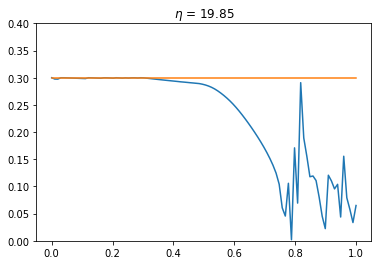

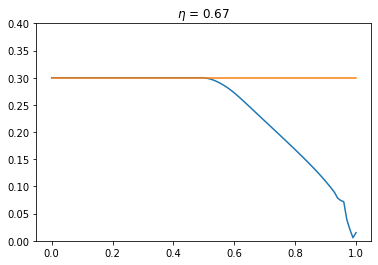

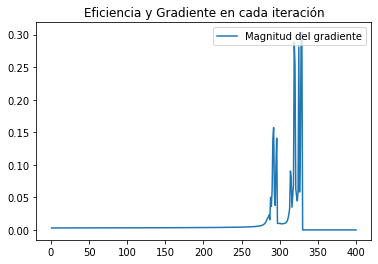

In [8]:
eta,thetas = eficiencia(perfil_prueba,params)

plt.figure()
plt.plot(np.linspace(0,L,nodos),perfil_prueba)
plt.plot(np.linspace(0,L,nodos),B0*np.ones(nodos))
plt.ylim(0,B0+0.1)
plt.title('$\eta$ = {:.2f}'.format(eta))

plt.figure()
plt.plot(np.linspace(0,L,nodos),perfiles[286])
plt.plot(np.linspace(0,L,nodos),B0*np.ones(nodos))
plt.ylim(0,B0+0.1)
plt.title('$\eta$ = {:.2f}'.format(etas[286]))

plt.figure()
plt.plot(np.linspace(1,len(cambio),len(cambio)),cambio,label='Magnitud del gradiente')
#plt.plot(np.linspace(1,len(cambio),len(cambio)),etas,label = 'Eficiencia')
plt.title('Eficiencia y Gradiente en cada iteración')
plt.legend(loc=1)

Text(0.5, 1.0, 'Perfil de temperaturas (Mejor perfil)')

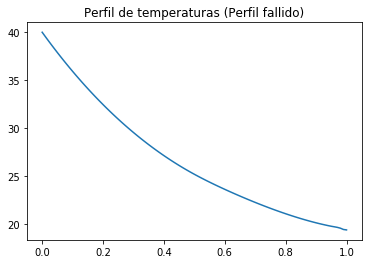

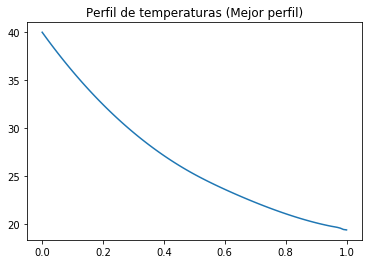

In [10]:
plt.figure()
plt.plot(np.linspace(0,L,nodos),thetas)
plt.title('Perfil de temperaturas (Perfil fallido)')

eta,thetas = eficiencia(perfiles[286],params)
plt.figure()
plt.plot(np.linspace(0,L,nodos),thetas)
plt.title('Perfil de temperaturas (Mejor perfil)')

# plt.figure()
# plt.plot(np.linspace(0,L,nodos),B0-np.linspace(0,B0,nodos),c='r')
# plt.plot(np.linspace(0,L,nodos),-0.3+np.linspace(0,0.3,nodos),c='r')

# plt.plot(np.linspace(0,L,nodos),B0*np.ones(nodos),c='b')
# plt.plot(np.linspace(0,L,nodos),0*np.ones(nodos),c='b')